#### Jupyter notebooks

This is a [Jupyter](http://jupyter.org/) notebook using Python.  You can install Jupyter locally to edit and interact with this notebook.

# Finite Difference methods in 2 dimensions

Let's start by generalizing the 1D Laplacian,

\begin{align} - u''(x) &= f(x) \text{ on } \Omega = (a,b) & u(a) &= g_0(a) & u'(b) = g_1(b) \end{align}

to two dimensions

\begin{align} -\nabla\cdot \big( \nabla u(x,y) \big) &= f(x,y) \text{ on } \Omega \subset \mathbb R^2
& u|_{\Gamma_D} &= g_0(x,y) & \nabla u \cdot \hat n|_{\Gamma_N} &= g_1(x,y)
\end{align}

where $\Omega$ is some well-connected open set (we will assume simply connected) and the Dirichlet boundary $\Gamma_D \subset \partial \Omega$ is nonempty.

We need to choose a system for specifying the domain $\Omega$ and ordering degrees of freedom.  Perhaps the most significant limitation of finite difference methods is that this specification is messy for complicated domains.  We will choose
$$ \Omega = (0, 1) \times (0, 1) $$
and
\begin{align} (x, y)_{im+j} &= (i h, j h) & h &= 1/(m-1) & i,j \in \{0, 1, \dotsc, m-1 \} .
\end{align}

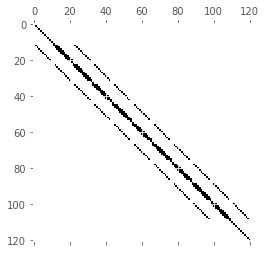

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

def laplacian2d_dense(h, f, g0):
    m = int(1/h + 1)
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    u0 = g0(x, y).flatten()
    rhs = f(x, y).flatten()
    A = numpy.zeros((m*m, m*m))
    def idx(i, j):
        return i*m + j
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            if i in (0, m-1) or j in (0, m-1):
                A[row, row] = 1
                rhs[row] = u0[row]
            else:
                cols = [idx(*pair) for pair in
                        [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]]
                stencil = 1/h**2 * numpy.array([-1, -1, 4, -1, -1])
                A[row, cols] = stencil
    return x, y, A, rhs

x, y, A, rhs = laplacian2d_dense(.1, lambda x,y: 0*x+1, lambda x,y: 0*x)

pyplot.spy(A);

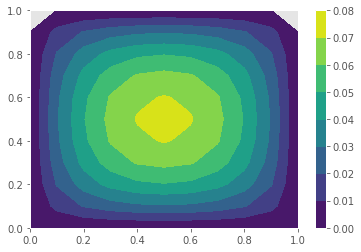

In [2]:
u = numpy.linalg.solve(A, rhs).reshape(x.shape)

pyplot.contourf(x, y, u)
pyplot.colorbar();

In [3]:
import cProfile
prof = cProfile.Profile()
prof.enable()
x, y, A, rhs = laplacian2d_dense(.0125, lambda x,y: 0*x+1, lambda x,y: 0*x)
u = numpy.linalg.solve(A, rhs).reshape(x.shape)
prof.disable()
prof.print_stats(sort='tottime')

         50365 function calls in 3.011 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    2.912    2.912    2.912    2.912 linalg.py:300(solve)
        1    0.070    0.070    0.098    0.098 <ipython-input-1-7008a012ae5b>:6(laplacian2d_dense)
     6251    0.012    0.000    0.012    0.000 {built-in method numpy.core.multiarray.array}
     6241    0.009    0.000    0.014    0.000 <ipython-input-1-7008a012ae5b>:22(<listcomp>)
    37766    0.006    0.000    0.006    0.000 <ipython-input-1-7008a012ae5b>:13(idx)
        1    0.000    0.000    0.000    0.000 {built-in method numpy.core.multiarray.arange}
        3    0.000    0.000    0.000    0.000 {built-in method builtins.compile}
        1    0.000    0.000    0.001    0.001 function_base.py:25(linspace)
        3    0.000    0.000    3.011    1.004 interactiveshell.py:2851(run_code)
        2    0.000    0.000    0.000    0.000 stride_tricks.py:115(_broadcast_to)
   

0.0

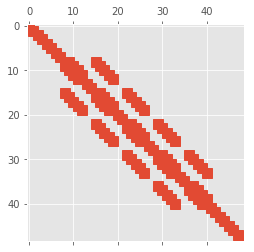

In [4]:
import scipy.sparse as sp
import scipy.sparse.linalg

def laplacian2d(h, f, g0):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    u0 = g0(x, y).flatten()
    rhs = f(x, y).flatten()
    A = sp.lil_matrix((m*m, m*m))
    def idx(i, j):
        return i*m + j
    mask = numpy.zeros_like(x, dtype=int)
    mask[1:-1,1:-1] = 1
    mask = mask.flatten()
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = numpy.array([idx(*pair) for pair in 
                                    [(i-1, j), (i, j-1),
                                     (i, j),
                                     (i, j+1), (i+1, j)]])
            stencilw = 1/h**2 * numpy.array([-1, -1, 4, -1, -1])
            if mask[row] == 0: # Dirichlet boundary
                A[row, row] = 1
                rhs[row] = u0[row]
            else:
                smask = mask[stencili]
                cols = stencili[smask == 1]
                A[row, cols] = stencilw[smask == 1]
                bdycols = stencili[smask == 0]
                rhs[row] -= stencilw[smask == 0] @ u0[bdycols]
    return x, y, A.tocsr(), rhs

x, y, A, rhs = laplacian2d(.15, lambda x,y: 0*x+1, lambda x,y: 0*x)

pyplot.spy(A);
sp.linalg.norm(A - A.T)

In [5]:
prof = cProfile.Profile()
prof.enable()
x, y, A, rhs = laplacian2d(.005, lambda x,y: 0*x+1, lambda x,y: 0*x)
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
prof.disable()
prof.print_stats(sort='tottime')

         5362376 function calls in 4.898 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   158406    0.776    0.000    1.057    0.000 stride_tricks.py:115(_broadcast_to)
        1    0.761    0.761    4.730    4.730 <ipython-input-4-e6a13d419593>:4(laplacian2d)
   516438    0.322    0.000    0.322    0.000 {built-in method numpy.core.multiarray.array}
    39601    0.280    0.000    0.280    0.000 {scipy.sparse._csparsetools.lil_fancy_set}
    40401    0.260    0.000    3.644    0.000 lil.py:333(__setitem__)
    79203    0.224    0.000    1.683    0.000 stride_tricks.py:195(broadcast_arrays)
    79202    0.173    0.000    0.358    0.000 sputils.py:331(_check_boolean)
    39601    0.165    0.000    1.635    0.000 sputils.py:351(_index_to_arrays)
        1    0.162    0.162    0.162    0.162 {built-in method scipy.sparse.linalg.dsolve._superlu.gssv}
    79203    0.156    0.000    0.166    0.000 stride_tricks.py:176(_broadcast

## A manufactured solution

(51, 51) 1.15397307746e-06


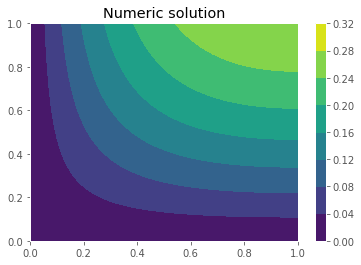

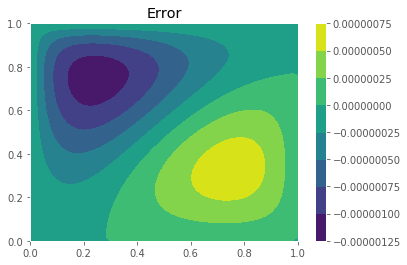

In [6]:
class mms0:
    def u(x, y):
        return x*numpy.exp(-x)*numpy.tanh(y)
    def grad_u(x, y):
        return numpy.array([(1 - x)*numpy.exp(-x)*numpy.tanh(y),
                            x*numpy.exp(-x)*(1 - numpy.tanh(y)**2)])
    def laplacian_u(x, y):
        return ((2 - x)*numpy.exp(-x)*numpy.tanh(y)
                - 2*x*numpy.exp(-x)*(numpy.tanh(y)**2 - 1)*numpy.tanh(y))
    def grad_u_dot_normal(x, y, n):
        return grad_u(x, y) @ n

x, y, A, rhs = laplacian2d(.02, mms0.laplacian_u, mms0.u)
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
print(u.shape, numpy.linalg.norm((u - mms0.u(x,y)).flatten(), numpy.inf))
pyplot.contourf(x, y, u)
pyplot.colorbar()
pyplot.title('Numeric solution')
pyplot.figure()
pyplot.contourf(x, y, u - mms0.u(x, y))
pyplot.colorbar()
pyplot.title('Error');

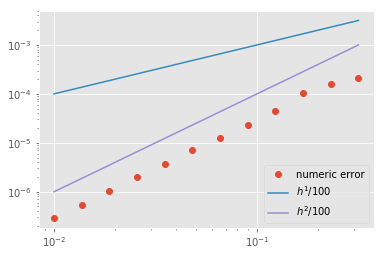

In [7]:
hs = numpy.logspace(-2, -.5, 12)
def mms_error(h):
    x, y, A, rhs = laplacian2d(h, mms0.laplacian_u, mms0.u)
    u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
    return numpy.linalg.norm((u - mms0.u(x, y)).flatten(), numpy.inf)

pyplot.loglog(hs, [mms_error(h) for h in hs], 'o', label='numeric error')
pyplot.loglog(hs, hs**1/100, label='$h^1/100$')
pyplot.loglog(hs, hs**2/100, label='$h^2/100$')
pyplot.legend();

# Neumann boundary conditions

Recall that in 1D, we would reflect the solution into ghost points according to

$$ u_{-i} = u_i - (x_i - x_{-i}) g_1(x_0, y) $$

and similarly for the right boundary and in the $y$ direction.  After this, we (optionally) scale the row in the matrix for symmetry and shift the known parts to the right hand side.  Below, we implement the reflected symmetry, but not the inhomogeneous contribution or rescaling of the matrix row.

[ 1. +0.00000000e+00j  1. +1.29546009e-14j  1. -1.29546009e-14j
  1. +0.00000000e+00j  1. +0.00000000e+00j  1. +0.00000000e+00j]


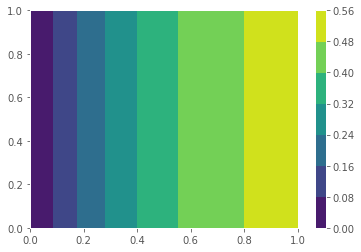

In [8]:
def laplacian2d_bc(h, f, g0, dirichlet=((),())):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    u0 = g0(x, y).flatten()
    rhs = f(x, y).flatten()
    ai = []
    aj = []
    av = []
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    mask = numpy.ones_like(x, dtype=int)
    mask[dirichlet[0],:] = 0
    mask[:,dirichlet[1]] = 0
    mask = mask.flatten()
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = numpy.array([idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
            stencilw = 1/h**2 * numpy.array([-1, -1, 4, -1, -1])
            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
                rhs[row] = u0[row]
            else:
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask == 1].tolist()
                av += stencilw[smask == 1].tolist()
                bdycols = stencili[smask == 0]
                rhs[row] -= stencilw[smask == 0] @ u0[bdycols]
    A = sp.csr_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return x, y, A, rhs

x, y, A, rhs = laplacian2d_bc(.05, lambda x,y: 0*x+1,
                              lambda x,y: 0*x, dirichlet=((0,),()))
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
print(sp.linalg.eigs(A, which='SM')[0])
pyplot.contourf(x, y, u)
pyplot.colorbar();

In [9]:
# We used a different technique for assembling the sparse matrix.
# This is faster with scipy.sparse, but may be worse for other sparse matrix packages, such as PETSc.

prof = cProfile.Profile()
prof.enable()
x, y, A, rhs = laplacian2d_bc(.005, lambda x,y: 0*x+1, lambda x,y: 0*x)
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
prof.disable()
prof.print_stats(sort='tottime')

         1454850 function calls (1454848 primitive calls) in 1.279 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.557    0.557    1.070    1.070 <ipython-input-8-3e7d847cec42>:1(laplacian2d_bc)
        1    0.203    0.203    0.203    0.203 {built-in method scipy.sparse.linalg.dsolve._superlu.gssv}
   242406    0.146    0.000    0.199    0.000 <ipython-input-8-3e7d847cec42>:11(idx)
    80841    0.141    0.000    0.141    0.000 {built-in method numpy.core.multiarray.array}
    40401    0.083    0.000    0.083    0.000 {built-in method builtins.sum}
   969624    0.053    0.000    0.053    0.000 {built-in method builtins.abs}
    40401    0.049    0.000    0.206    0.000 <ipython-input-8-3e7d847cec42>:22(<listcomp>)
    80802    0.021    0.000    0.021    0.000 {method 'tolist' of 'numpy.ndarray' objects}
        1    0.012    0.012    0.012    0.012 {built-in method numpy.core.multiarray.lexsort}
        1    0

# Variable coefficients

In physical systems, it is common for equations to be given in **divergence form** (sometimes called **conservative form**),
$$ -\nabla\cdot \Big( \kappa(x,y) \nabla u \Big) = f(x,y) . $$
This can be converted to **non-divergence form**,
$$ - \kappa(x,y) \nabla\cdot \nabla u - \nabla \kappa(x,y) \cdot \nabla u = f(x,y) . $$

* What assumptions did we just make on $\kappa(x,y)$?

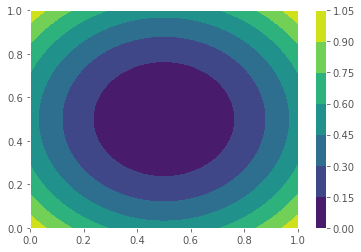

In [10]:
def laplacian2d_nondiv(h, f, kappa, grad_kappa, g0, dirichlet=((),())):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    u0 = g0(x, y).flatten()
    rhs = f(x, y).flatten()
    ai = []
    aj = []
    av = []
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    mask = numpy.ones_like(x, dtype=int)
    mask[dirichlet[0],:] = 0
    mask[:,dirichlet[1]] = 0
    mask = mask.flatten()
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = numpy.array([idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
            stencilw = kappa(i*h, j*h)/h**2 * numpy.array([-1, -1, 4, -1, -1])
            if grad_kappa is None:
                gk = 1/h * numpy.array([kappa((i+.5)*h,j*h) - kappa((i-.5)*h,j*h),
                                        kappa(i*h,(j+.5)*h) - kappa(i*h,(j-.5)*h)])
            else:
                gk = grad_kappa(i*h, j*h)
            stencilw -= gk[0] / (2*h) * numpy.array([-1, 0, 0, 0, 1])
            stencilw -= gk[1] / (2*h) * numpy.array([0, -1, 0, 1, 0]) 
            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
                rhs[row] = u0[row]
            else:
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask == 1].tolist()
                av += stencilw[smask == 1].tolist()
                bdycols = stencili[smask == 0]
                rhs[row] -= stencilw[smask == 0] @ u0[bdycols]
    A = sp.csr_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return x, y, A, rhs

def kappa(x, y):
    #return 1 - 2*(x-.5)**2 - 2*(y-.5)**2
    return 1e-2 + 2*(x-.5)**2 + 2*(y-.5)**2
def grad_kappa(x, y):
    #return -4*(x-.5), -4*(y-.5)
    return 4*(x-.5), 4*(y-.5)

pyplot.contourf(x, y, kappa(x,y))
pyplot.colorbar();

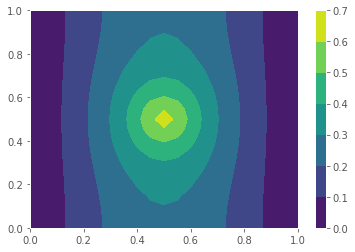

In [11]:
x, y, A, rhs = laplacian2d_nondiv(.05, lambda x,y: 0*x+1,
                                  kappa, grad_kappa,
                                  lambda x,y: 0*x, dirichlet=((0,-1),()))
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.contourf(x, y, u)
pyplot.colorbar();

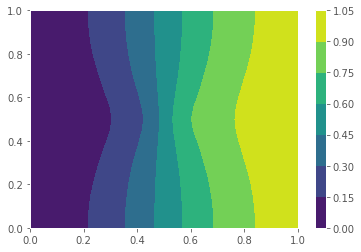

In [12]:
x, y, A, rhs = laplacian2d_nondiv(.05, lambda x,y: 0*x,
                                  kappa, grad_kappa,
                                  lambda x,y: x, dirichlet=((0,-1),()))
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.contourf(x, y, u)
pyplot.colorbar();

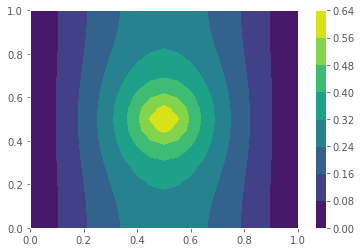

In [13]:
def laplacian2d_div(h, f, kappa, g0, dirichlet=((),())):
    m = int(1/h + 1)  # Number of elements in terms of nominal grid spacing h
    h = 1 / (m-1)     # Actual grid spacing
    c = numpy.linspace(0, 1, m)
    y, x = numpy.meshgrid(c, c)
    u0 = g0(x, y).flatten()
    rhs = f(x, y).flatten()
    ai = []
    aj = []
    av = []
    def idx(i, j):
        i = (m-1) - abs(m-1 - abs(i))
        j = (m-1) - abs(m-1 - abs(j))
        return i*m + j
    mask = numpy.ones_like(x, dtype=int)
    mask[dirichlet[0],:] = 0
    mask[:,dirichlet[1]] = 0
    mask = mask.flatten()
    for i in range(m):
        for j in range(m):
            row = idx(i, j)
            stencili = numpy.array([idx(*pair) for pair in [(i-1, j), (i, j-1), (i, j), (i, j+1), (i+1, j)]])
            stencilw = 1/h**2 * (  kappa((i-.5)*h, j*h) * numpy.array([-1, 0, 1, 0, 0])
                                 + kappa(i*h, (j-.5)*h) * numpy.array([0, -1, 1, 0, 0])
                                 + kappa(i*h, (j+.5)*h) * numpy.array([0, 0, 1, -1, 0])
                                 + kappa((i+.5)*h, j*h) * numpy.array([0, 0, 1, 0, -1]))
            if mask[row] == 0: # Dirichlet boundary
                ai.append(row)
                aj.append(row)
                av.append(1)
                rhs[row] = u0[row]
            else:
                smask = mask[stencili]
                ai += [row]*sum(smask)
                aj += stencili[smask == 1].tolist()
                av += stencilw[smask == 1].tolist()
                bdycols = stencili[smask == 0]
                rhs[row] -= stencilw[smask == 0] @ u0[bdycols]
    A = sp.csr_matrix((av, (ai, aj)), shape=(m*m,m*m))
    return x, y, A, rhs

x, y, A, rhs = laplacian2d_div(.05, lambda x,y: 0*x+1,
                                  kappa,
                                  lambda x,y: 0*x, dirichlet=((0,-1),()))
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.contourf(x, y, u)
pyplot.colorbar();

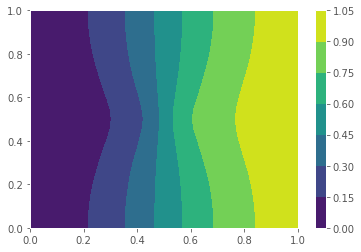

In [14]:
x, y, A, rhs = laplacian2d_div(.05, lambda x,y: 0*x,
                                  kappa,
                                  lambda x,y: x, dirichlet=((0,-1),()))
u = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.contourf(x, y, u)
pyplot.colorbar();

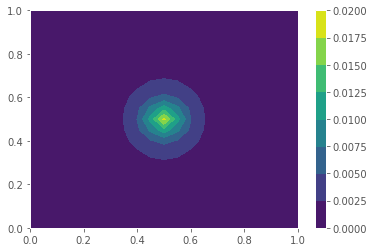

In [15]:
x, y, A, rhs = laplacian2d_nondiv(.05, lambda x,y: 0*x+1,
                                  kappa, grad_kappa,
                                  lambda x,y: 0*x, dirichlet=((0,-1),()))
u_nondiv = sp.linalg.spsolve(A, rhs).reshape(x.shape)

x, y, A, rhs = laplacian2d_div(.05, lambda x,y: 0*x+1,
                                  kappa,
                                  lambda x,y: 0*x, dirichlet=((0,-1),()))
u_div = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.contourf(x, y, u_nondiv - u_div)
pyplot.colorbar();

(5.5463698418398155e-05,)

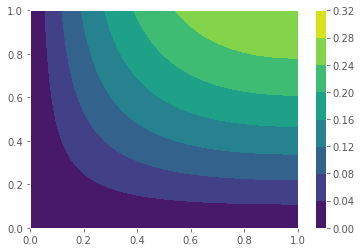

In [16]:
class mms1:
    def __init__(self):
        import sympy
        x, y = sympy.symbols('x y')
        uexpr = x*sympy.exp(-x) * sympy.tanh(y)
        kexpr = 1e-2 + 2*(x-.42)**2 + 2*(y-.51)**2
        self.u = sympy.lambdify((x,y), uexpr)
        self.kappa = sympy.lambdify((x,y), kexpr)
        def grad_kappa(xx, yy):
            kx = sympy.lambdify((x,y), sympy.diff(kexpr, x))
            ky = sympy.lambdify((x,y), sympy.diff(kexpr, y))
            return kx(xx, yy), ky(xx, yy)
        self.grad_kappa = grad_kappa
        self.div_kappa_grad_u = sympy.lambdify((x,y),
                                              -(  sympy.diff(kexpr * sympy.diff(uexpr, x), x)
                                                + sympy.diff(kexpr * sympy.diff(uexpr, y), y)))
        
mms = mms1()
x, y, A, rhs = laplacian2d_nondiv(.05, mms.div_kappa_grad_u,
                                  mms.kappa, mms.grad_kappa,
                                  mms.u, dirichlet=((0,-1),(0,-1)))
u_nondiv = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.contourf(x, y, u_nondiv)
pyplot.colorbar()
numpy.linalg.norm((u_nondiv - mms.u(x, y)).flatten(), numpy.inf), 

0.00043339477229495382

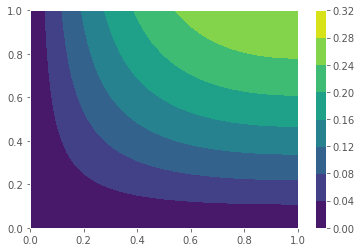

In [17]:
x, y, A, rhs = laplacian2d_div(.05, mms.div_kappa_grad_u,
                                  mms.kappa,
                                  mms.u, dirichlet=((0,-1),(0,-1)))
u_div = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.contourf(x, y, u_div)
pyplot.colorbar()
numpy.linalg.norm((u_div - mms.u(x, y)).flatten(), numpy.inf)

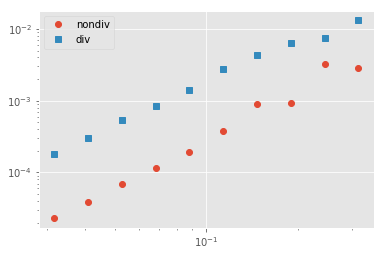

In [18]:
def mms_error(h):
    x, y, A, rhs = laplacian2d_nondiv(h, mms.div_kappa_grad_u,
                                  mms.kappa, mms.grad_kappa,
                                  mms.u, dirichlet=((0,-1),(0,-1)))
    u_nondiv = sp.linalg.spsolve(A, rhs).flatten()
    x, y, A, rhs = laplacian2d_div(h, mms.div_kappa_grad_u,
                                  mms.kappa, mms.u, dirichlet=((0,-1),(0,-1)))
    u_div = sp.linalg.spsolve(A, rhs).flatten()
    u_exact = mms.u(x, y).flatten()
    return numpy.linalg.norm(u_nondiv - u_exact, numpy.inf), numpy.linalg.norm(u_div - u_exact, numpy.inf)

hs = numpy.logspace(-1.5, -.5, 10)
errors = numpy.array([mms_error(h) for h in hs])
pyplot.loglog(hs, errors[:,0], 'o', label='nondiv')
pyplot.loglog(hs, errors[:,1], 's', label='div')
pyplot.legend();

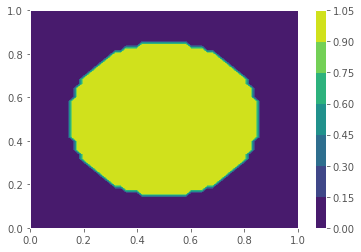

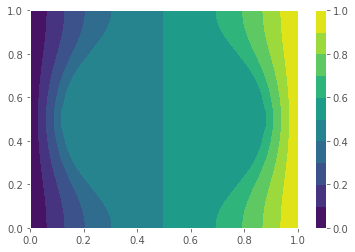

In [19]:
kappablob = lambda x,y: .01 + ((x-.5)**2 + (y-.5)**2 < .125)
x, y, A, rhs = laplacian2d_div(.02, lambda x,y: 0*x, kappablob,
                                  lambda x,y:x, dirichlet=((0,-1),()))
u_div = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.contourf(x, y, kappablob(x, y))
pyplot.colorbar();
pyplot.figure()
pyplot.contourf(x, y, u_div, 10)
pyplot.colorbar();

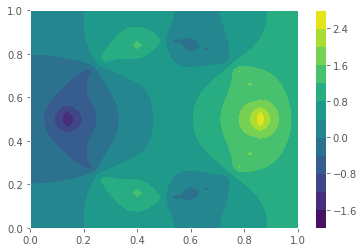

In [20]:
kappablob = lambda x,y: .01 + ((x-.5)**2 + (y-.5)**2 < .125)
x, y, A, rhs = laplacian2d_nondiv(.02, lambda x,y: 0*x, kappablob, None,
                                  lambda x,y:x, dirichlet=((0,-1),()))
u_nondiv = sp.linalg.spsolve(A, rhs).reshape(x.shape)
pyplot.contourf(x, y, u_nondiv, 10)
pyplot.colorbar();